In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
az.rcParams["plot.density_kind"] = "hist"
rng = np.random.default_rng(seed=42)


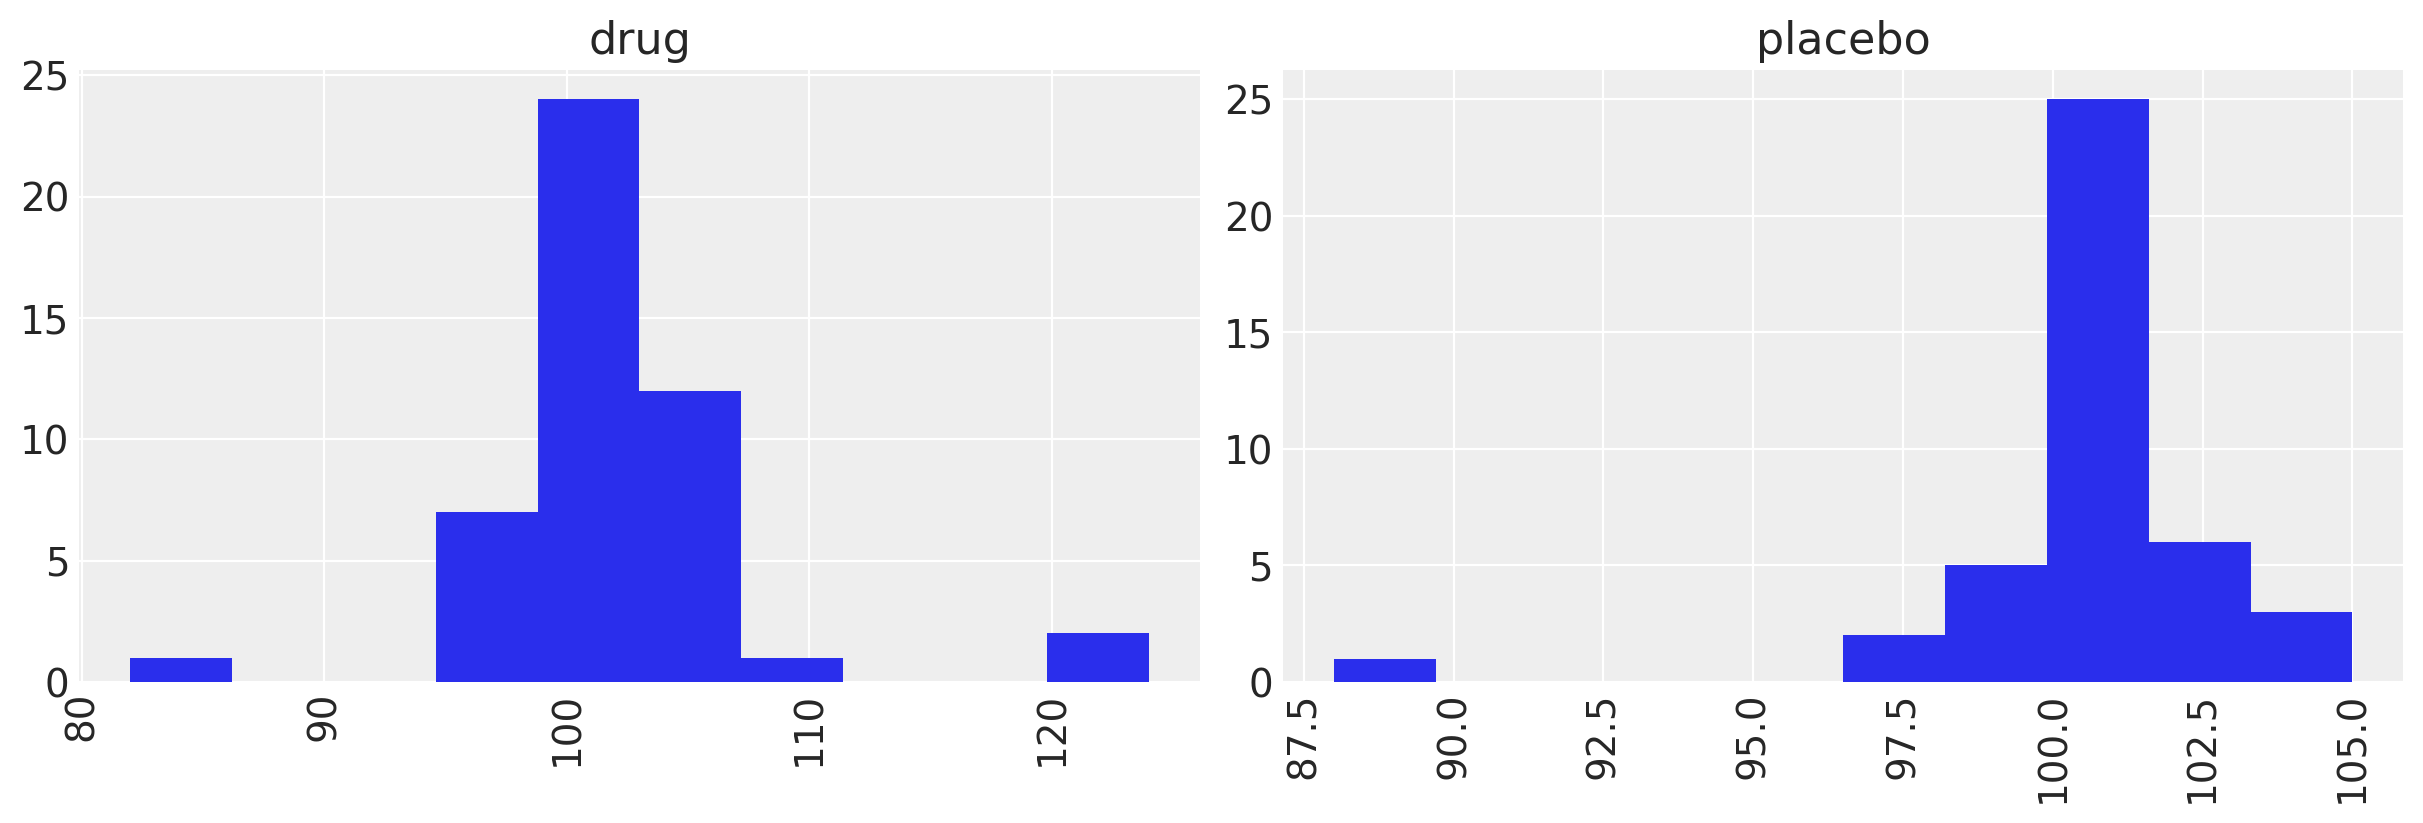

In [3]:
# Using data from pymc3 port of Kruschke's BEST model (see: 
# https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html)
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(
    dict(value=np.r_[y1, y2], group=np.r_[["drug"] * len(drug), ["placebo"] * len(placebo)])
)

y.hist("value", by="group", figsize=(12, 4));

In [4]:
# Call your Bayesian function from the toolbox
model, idata = bst.BEST(y["value"], y["group"], 2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group1_mean, group2_mean, group1_std, group2_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8886, but should be close to 0.8. Try to increase the number of tuning steps.


In [5]:
# Print out a summary of results
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group1_mean,101.549,0.379,100.820,102.311,0.005,0.003,7035.0,5579.0,1.0
group2_mean,100.526,0.213,100.125,100.952,0.002,0.002,7731.0,5857.0,1.0
group1_std,2.051,0.431,1.272,2.917,0.005,0.004,6012.0,4949.0,1.0
group2_std,1.046,0.208,0.673,1.468,0.003,0.002,6122.0,4485.0,1.0
nu_minus_one,0.830,0.470,0.017,1.687,0.006,0.005,4528.0,3542.0,1.0
nu,1.830,0.470,1.017,2.687,0.006,0.005,4528.0,3542.0,1.0
nu_log10,0.249,0.106,0.046,0.453,0.002,0.001,4528.0,3542.0,1.0
difference of means,1.023,0.429,0.159,1.828,0.005,0.004,7002.0,5752.0,1.0
difference of stds,1.005,0.437,0.152,1.844,0.005,0.004,7420.0,6019.0,1.0
effect size,0.646,0.291,0.105,1.243,0.003,0.002,6949.0,5730.0,1.0


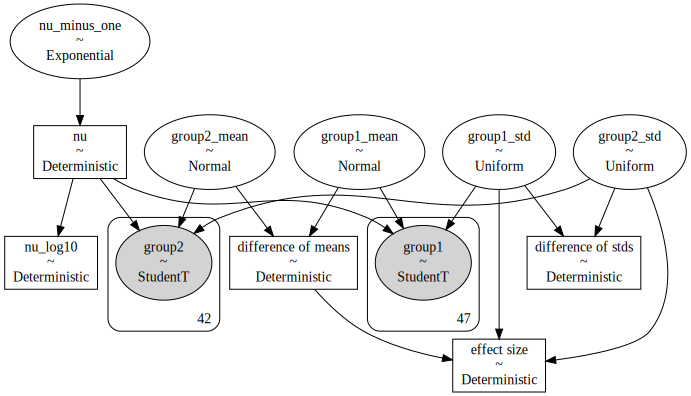

In [6]:
pm.model_to_graphviz(model)

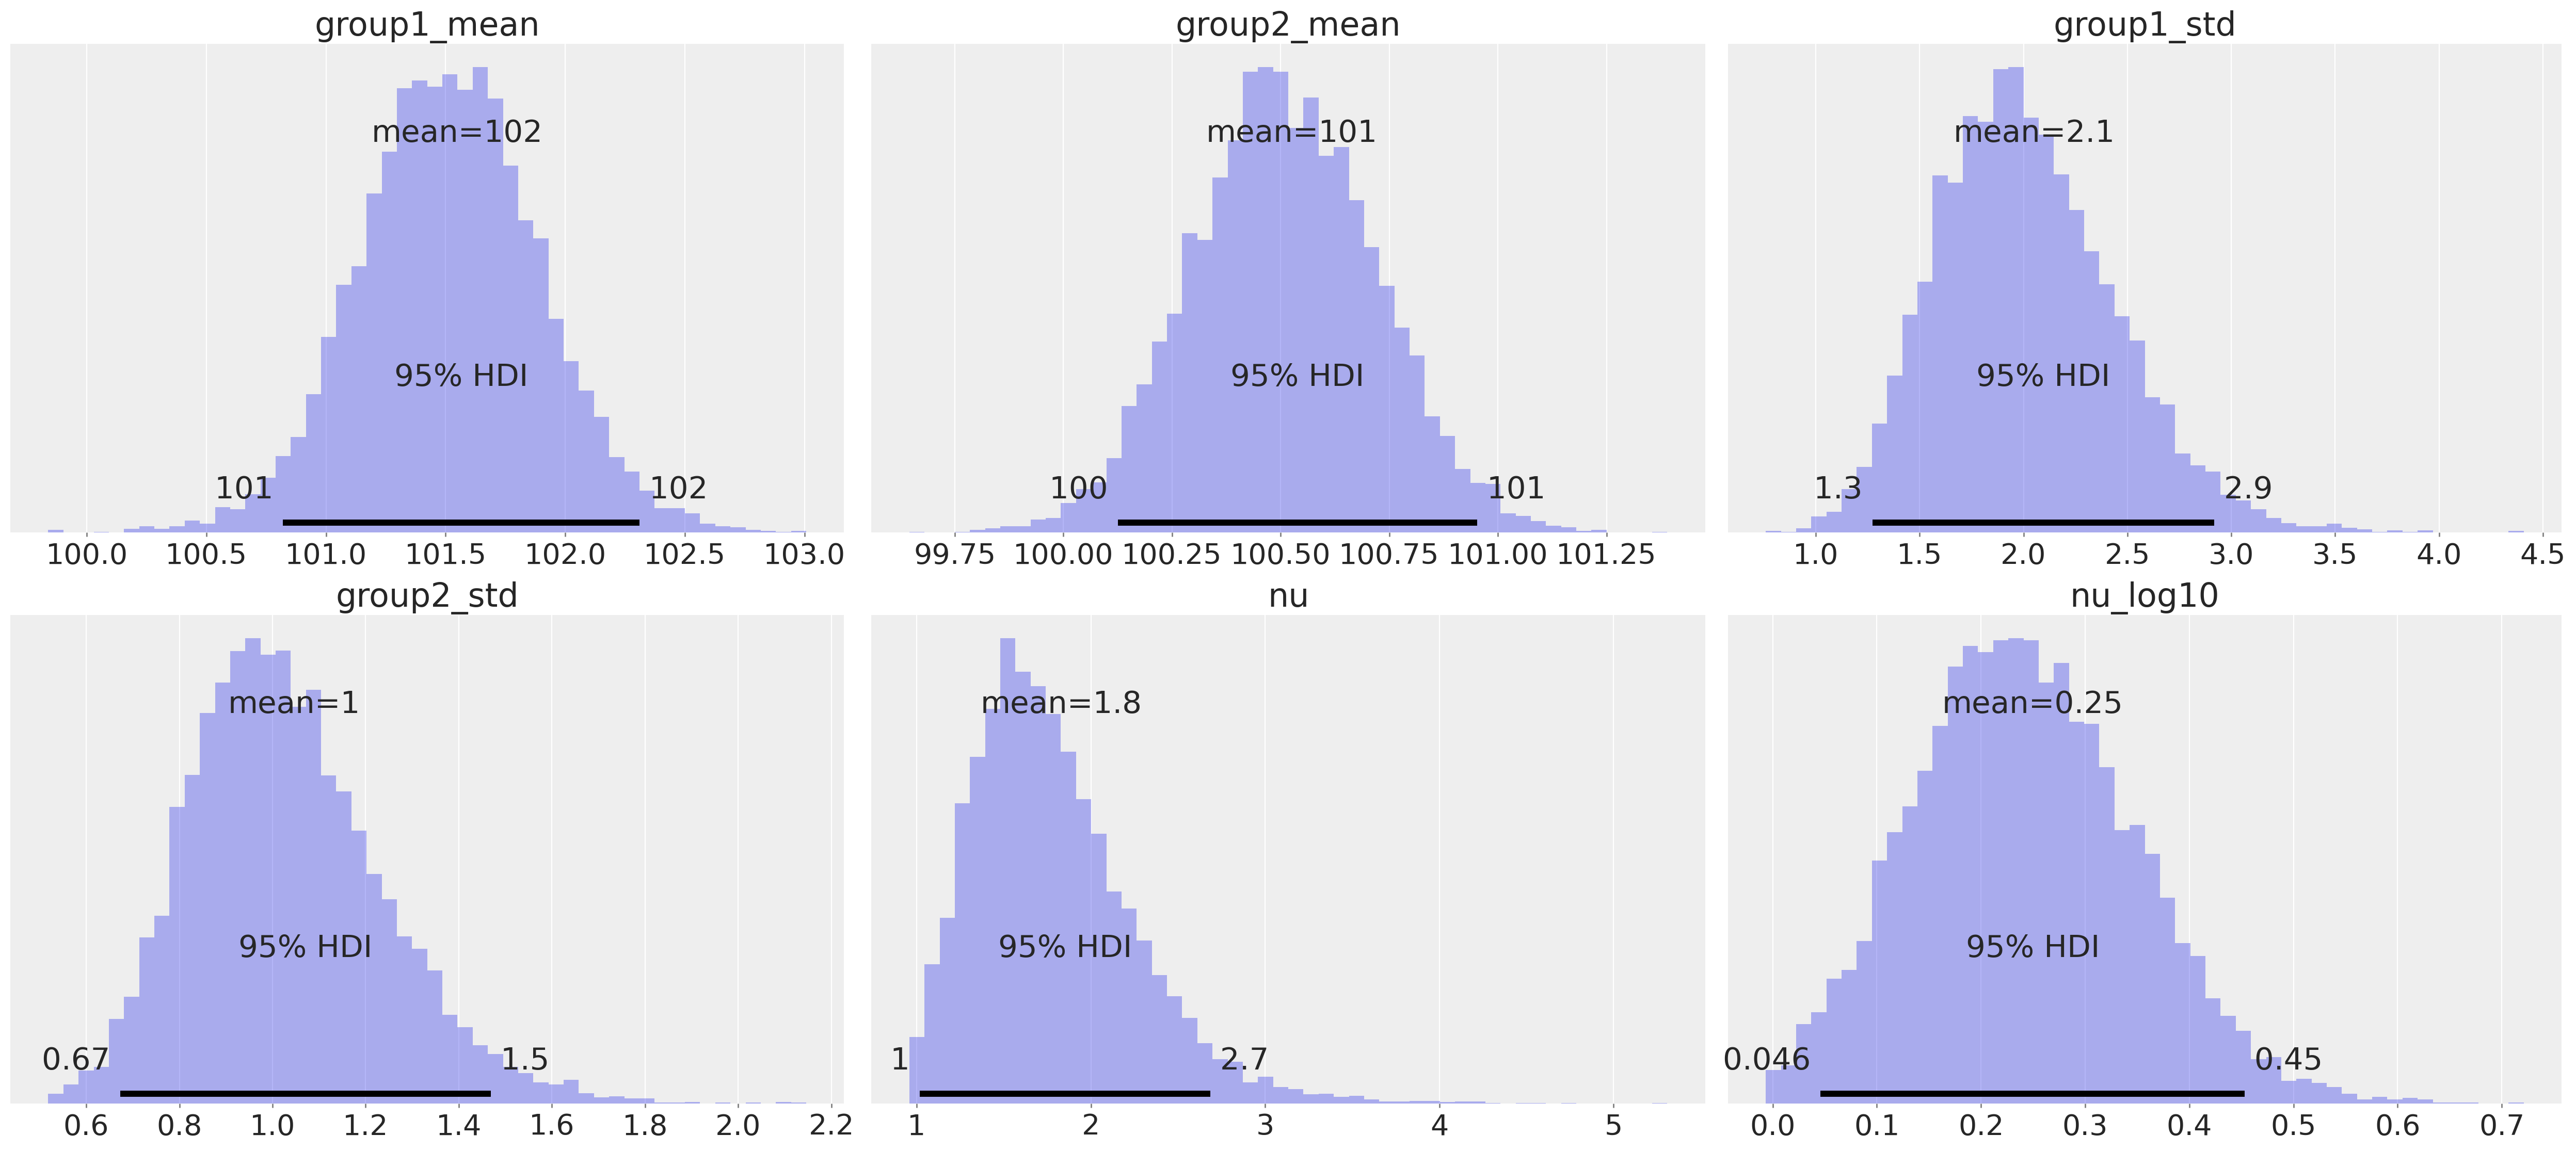

In [8]:
# Plot posterior
az.plot_posterior(
    idata,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "nu", "nu_log10"],
    bins=50,
    textsize=20
);

In [ ]:
# idata_posterior = idata.posterior


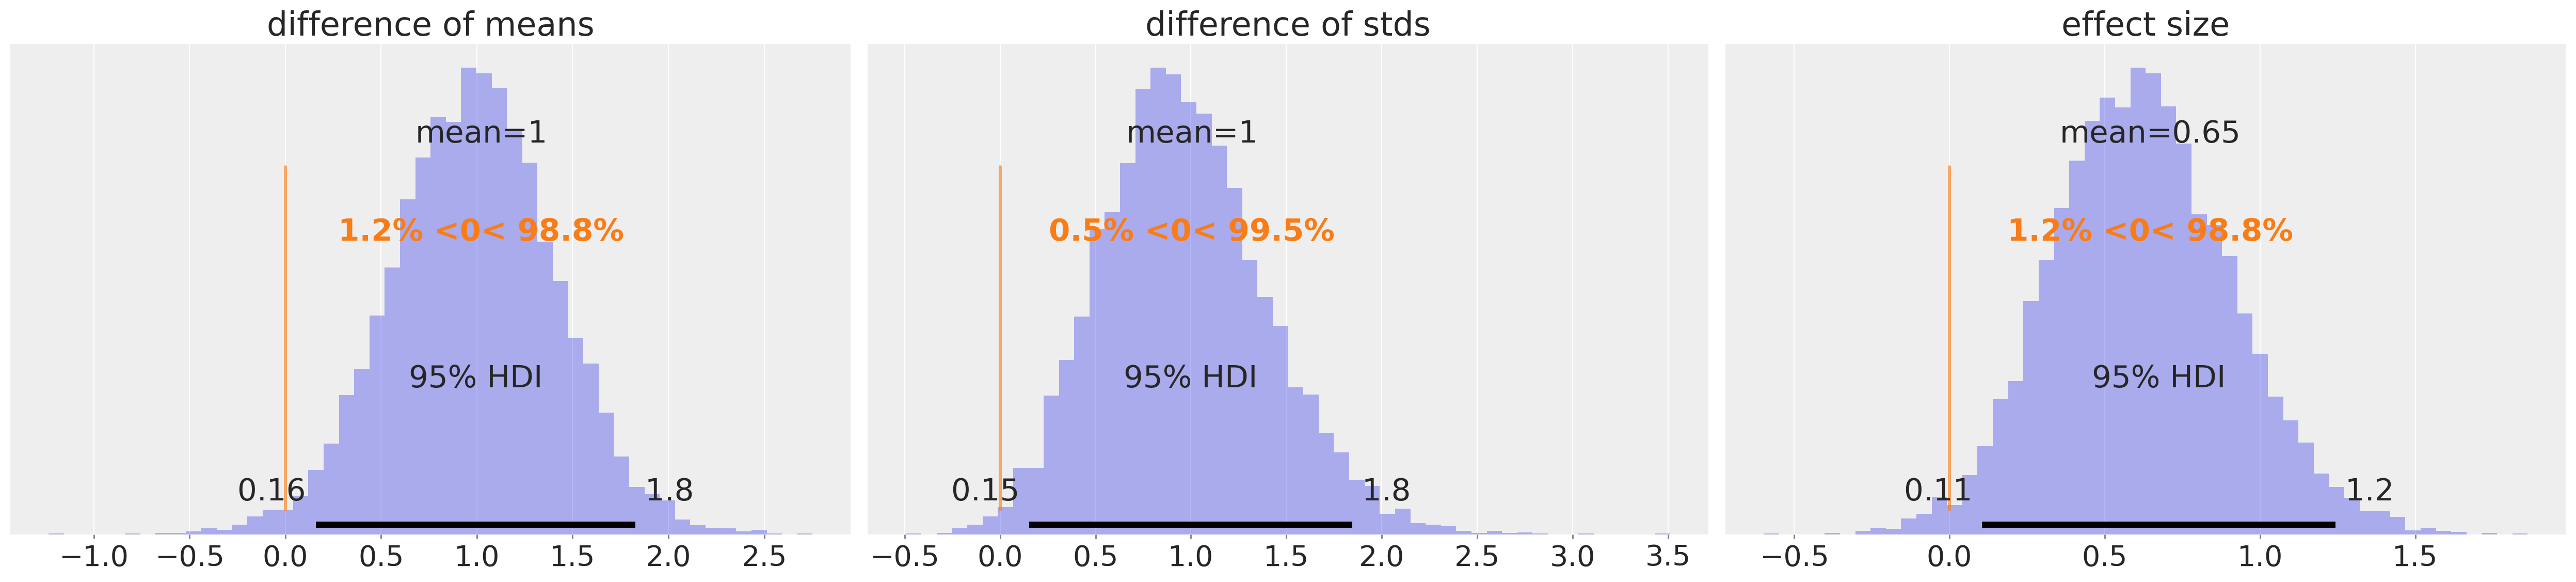

In [9]:
# Plot posterior
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    bins=50,
    textsize=20
);

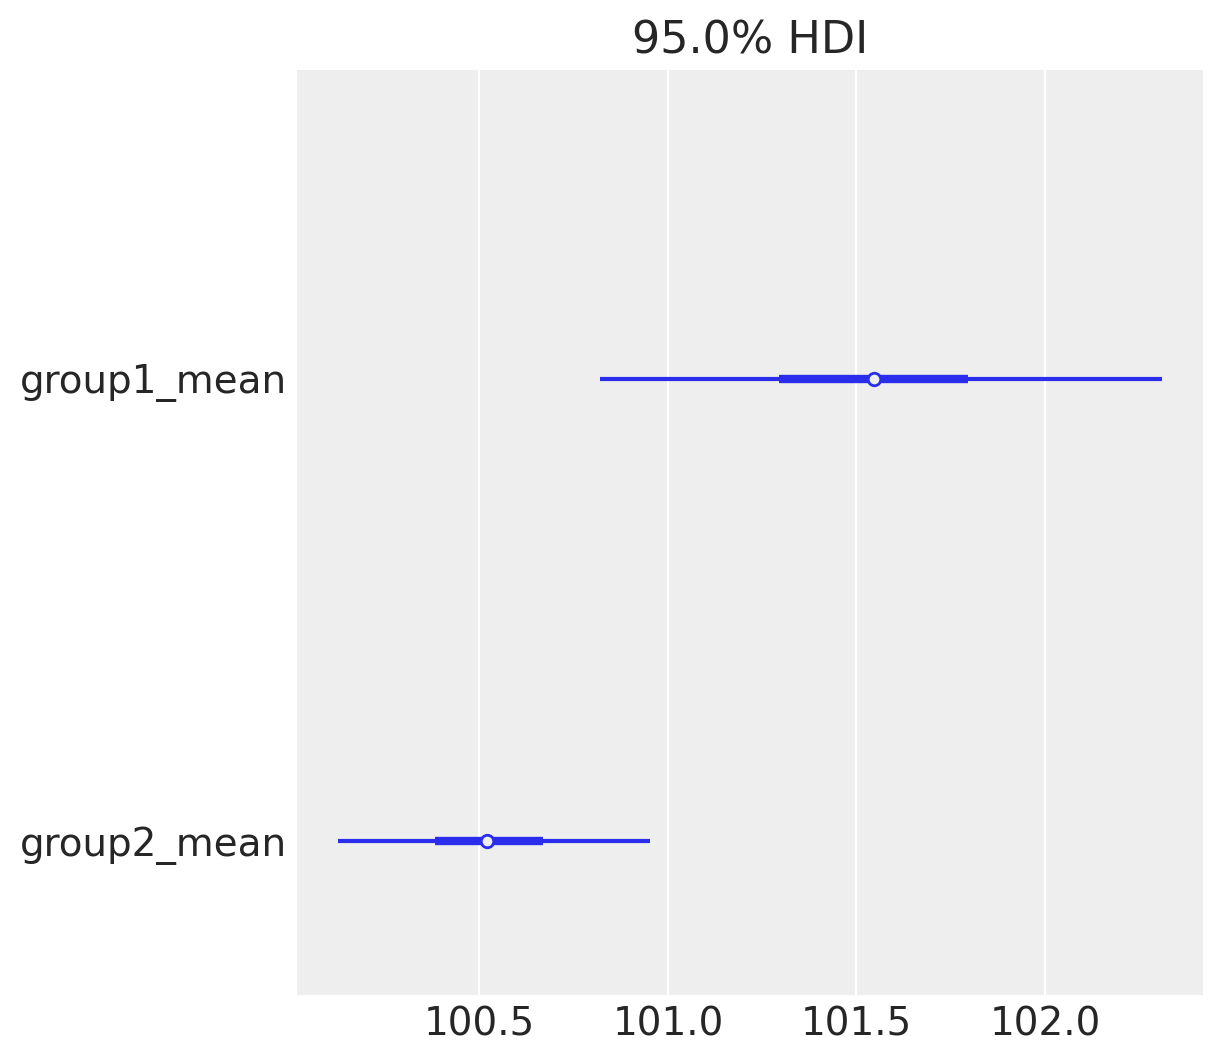

In [10]:
# Plot parameter estimates
az.plot_forest(idata, var_names=["group1_mean", "group2_mean"], combined=True);

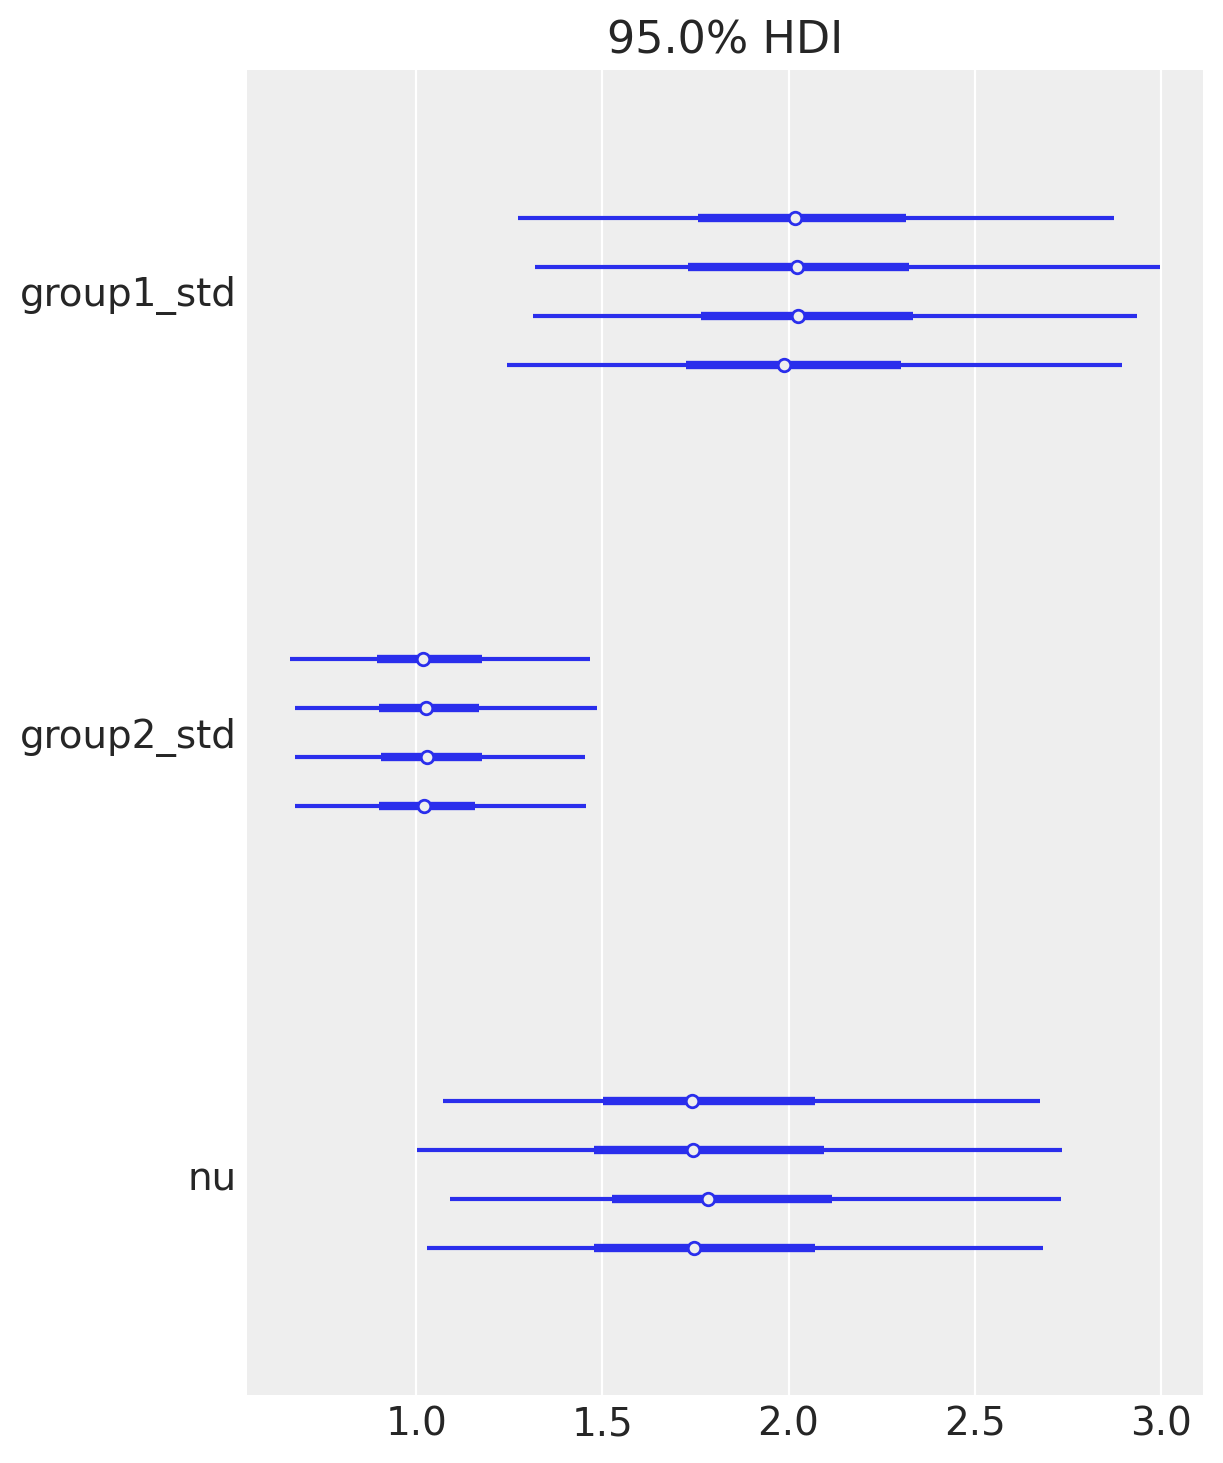

In [11]:
# Plot parameter estimates
az.plot_forest(idata, var_names=["group1_std", "group2_std", "nu"]);

In [12]:
# If you want to print the model so that you edit, simply add two question marks after the function name.
bst.BEST??

Signature: bst.BEST(y, group, n_draws=1000)
Docstring: <no docstring>
Source:   
def BEST(y, group, n_draws=1000):
    
    # Convert grouping variable to categorical dtype if it is not already
    if pd.api.types.is_categorical_dtype(group):
        pass
    else:
        group = group.astype('category')
        
    # Extract group levels and make sure there are only two
    level = group.cat.categories
    assert len(level) == 2, f"Expected two groups but got {len(level)}."
    
    # Split observations by group
    y_group1 = y[group==level[0]]
    y_group2 = y[group==level[1]]
    
    # Calculate pooled empirical mean and SD of data to scale hyperparameters
    mu_y = y.mean()
    sigma_y = y.std()
    
    # Arbitrarily set hyperparameters to the pooled empirical mean of data and 
    # twice pooled empirical SD, which applies very diffuse info to these 
    # quantities and does not favor one or the other a priori
    mu_m = mu_y
    mu_s = sigma_y * 2
                         

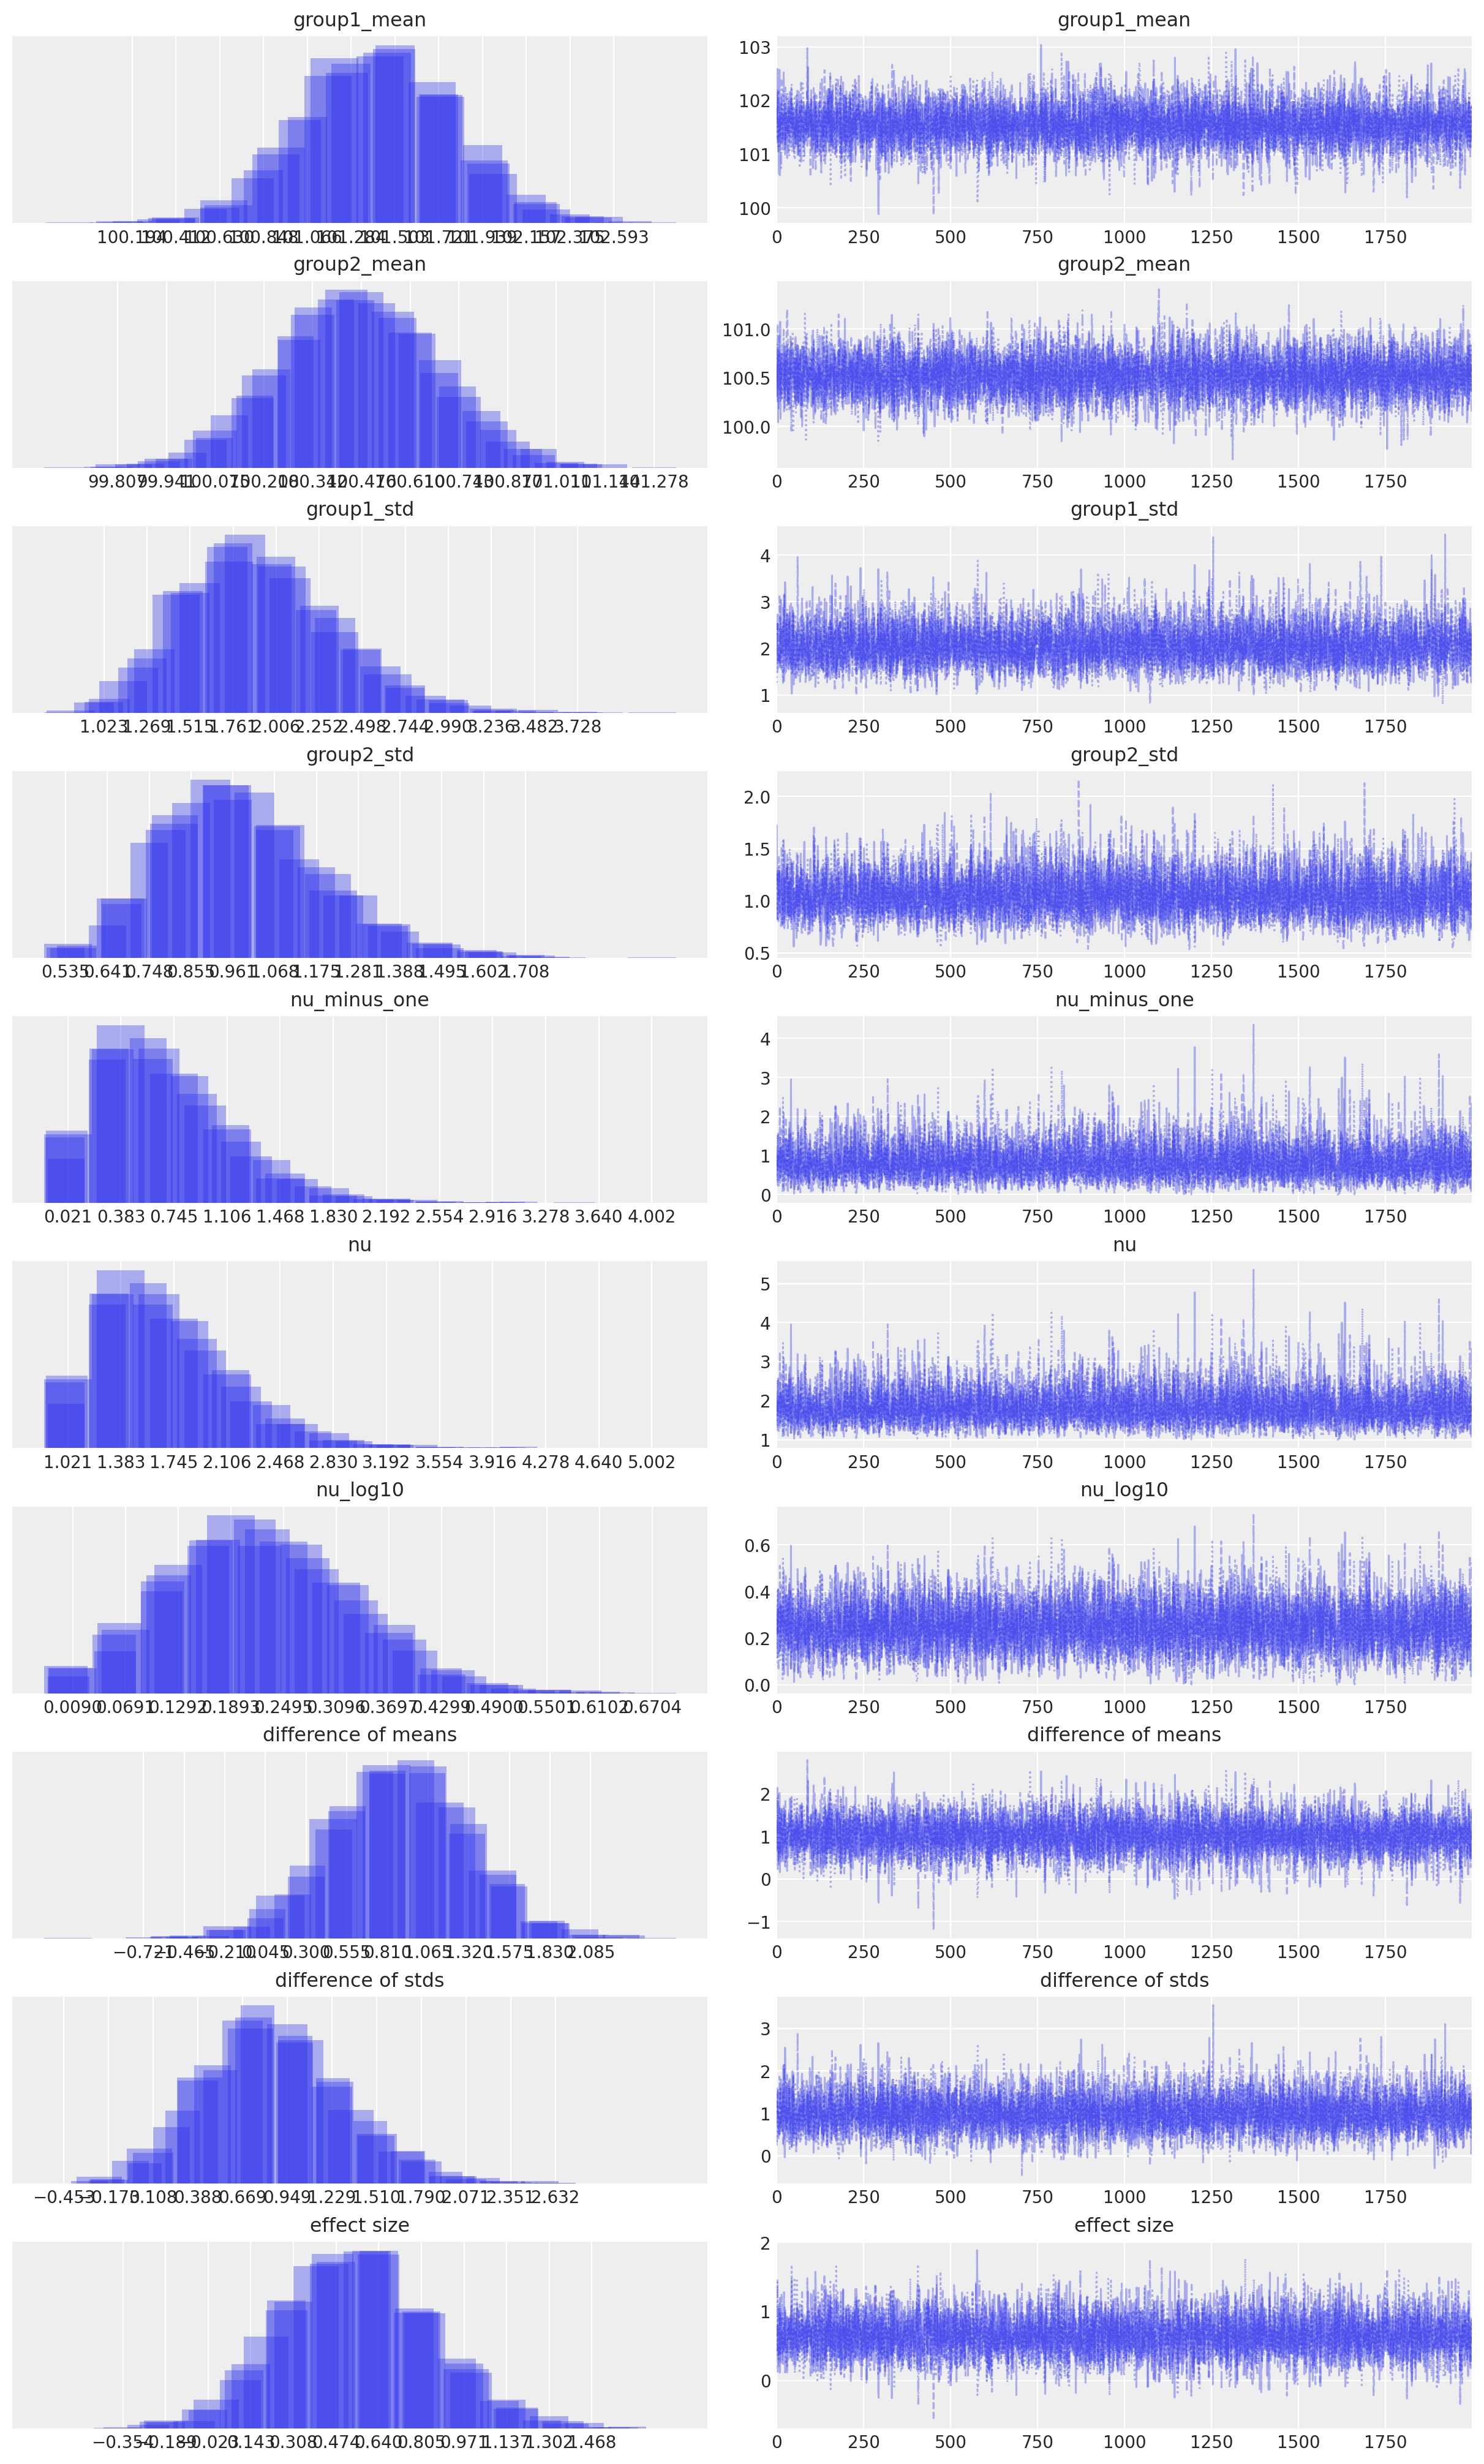

In [13]:
# Assess your MCMC chains.
az.plot_trace(idata);

In [ ]:
# Posterior predictive check
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
az.plot_ppc(idata, var_names=["group1", "group2"], num_pp_samples=50);

In [ ]:
az.rcParams.keys()

In [ ]:
plt.rcParams